## RQ2: Essay - Skill Profiling and Cross-Domain Performance

To investigate whether essay skill profiles relate to performance in other domains, we applied dimensionality reduction and clustering techniques on students' essay scores across multiple skill dimensions. Using PCA followed by K-means clustering, we grouped students based on their writing skill profiles.
We then compared the resulting clusters' average performance in both mathematics and text-based quizzes. The analysis revealed cross-domain consistency: students with stronger essay profiles tended to perform better in other subjects as well, suggesting a general underlying proficiency.

### 1. Initialization and Feature Extraction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Principal package imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import root_mean_squared_error, mean_squared_error, roc_auc_score

# PyBKT package imports
import random
old_randint = random.randint
random.randint = lambda a, b: old_randint(a, int(b))
from pyBKT.models import Model
random.randint = old_randint

,Unnamed: 0,user_id,course,textType,time,text,content-on_topic,content-plausible,content-convincing_ideas,content-scope,...,structure-coherence,structure-outline,structure-repetition,structure-text_pattern,language-clarity,language-spelling,language-puncutation,language-word_choice,language_sentence-structure,language_style
0,0,3203,5447,erzaehlung,1720779707,1. Versprochen!\n\nHanni und Ella waren beste ...,10,5,9,5,...,9.00000,4.00000,4.00000,5.00000,4,4,4,4,4,3
1,1,3203,5447,erzaehlung,1722615169,Lachen ist die beste Medizin\n\nIm Restaurant ...,10,5,9,5,...,9.00000,5.00000,4.00000,5.00000,5,4,4,5,4,4
2,2,3526,5447,erzaehlung,1722856654,"""Blöde Kuh? Vonwegen!""\n\nAn einem sonnigen Mo...",9,4,8,5,...,7.00000,4.00000,4.00000,4.00000,4,3,3,4,3,3
3,3,3526,5447,erzaehlung,1723017214,Versprochen!\nIch und Meine Freundin sind zusa...,2,4,6,4,...,6.00000,3.00000,3.00000,2.00000,3,2,2,3,3,2
4,4,3514,5447,erzaehlung,1723119172,Lachen ist die beste Medizin!\n\nIm Restaurant...,7,5,6,5,...,9.00000,4.00000,5.00000,5.00000,5,4,4,5,5,4


Cleaned grading dataset shape: (1983, 20)


/tmp/ipykernel_122/1984410410.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=user_bin_counts.index, y=user_bin_counts.values, palette='Blues_d')


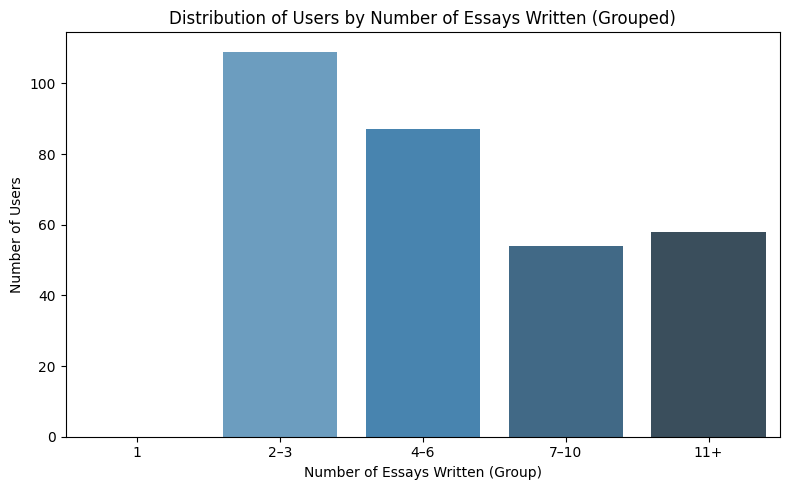

In [2]:
essay_res_df = pd.read_csv("/home/mlbd-project/updated_data/essay_results.csv")
display(essay_res_df.head())

# 2. Drop the 'content-correct' column
essay_res_df = essay_res_df.drop(columns=["content-correct"])

# 4. Drop rows with missing values in structure-* columns
structure_columns = [col for col in essay_res_df.columns if col.startswith("structure-")]
essay_res_df = essay_res_df.dropna(subset=structure_columns)

# 5. Check new shape of the cleaned dataset
print("Cleaned grading dataset shape:", essay_res_df.shape)

# Count number of essays per user
user_essay_counts = essay_res_df['user_id'].value_counts()

# Bin users based on number of essays written
bins = [0, 1, 3, 6, 10, user_essay_counts.max()+1]
labels = ['1', '2–3', '4–6', '7–10', '11+']
user_essay_bins = pd.cut(user_essay_counts, bins=bins, labels=labels, right=False)

# Count number of users in each bin
user_bin_counts = user_essay_bins.value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=user_bin_counts.index, y=user_bin_counts.values, palette='Blues_d')
plt.title("Distribution of Users by Number of Essays Written (Grouped)")
plt.xlabel("Number of Essays Written (Group)")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

In [3]:
# Define grading columns
grading_columns = [
    "content-on_topic", "content-plausible", "content-convincing_ideas", "content-scope",
    "structure-coherence", "structure-outline", "structure-repetition", "structure-text_pattern",
    "language-clarity", "language-spelling", "language-puncutation",
    "language-word_choice", "language_sentence-structure", "language_style"
]

# Compute average scores per user across grading dimensions
user_avg_grades = essay_res_df.groupby('user_id')[grading_columns].mean()

# (Optional) Compute average of all grading scores as a single metric
# user_avg_grades['avg_total_grade'] = user_avg_grades.mean(axis=1)

# Display the first few rows
display(user_avg_grades)

,content-on_topic,content-plausible,content-convincing_ideas,content-scope,structure-coherence,structure-outline,structure-repetition,structure-text_pattern,language-clarity,language-spelling,language-puncutation,language-word_choice,language_sentence-structure,language_style
user_id,,,,,,,,,,,,,,
1,6.50000,4.00000,5.50000,3.50000,6.00000,3.00000,3.00000,3.00000,3.00000,2.00000,2.00000,3.00000,3.00000,2.00000
4,8.33333,4.00000,7.33333,4.33333,6.66667,3.33333,3.66667,3.66667,3.33333,3.00000,3.33333,3.33333,3.00000,2.33333
5,0.00000,0.00000,0.00000,0.00000,8.00000,4.00000,4.00000,4.00000,3.00000,4.00000,3.00000,3.00000,3.00000,2.00000
6,8.57143,4.00000,7.28571,4.42857,7.28571,3.57143,3.57143,3.85714,3.71429,2.85714,3.00000,3.57143,3.14286,2.42857
7,9.25000,4.25000,7.75000,4.50000,8.00000,4.00000,4.00000,4.50000,3.75000,3.00000,3.00000,3.50000,3.25000,2.75000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4086,9.16667,4.66667,7.66667,4.50000,8.33333,4.16667,4.16667,4.33333,4.33333,3.50000,3.66667,4.16667,4.00000,3.66667
4087,8.50000,4.00000,7.00000,4.00000,6.50000,3.00000,3.50000,3.50000,3.50000,3.00000,3.00000,3.50000,3.00000,2.50000
4089,8.00000,3.00000,6.00000,4.00000,5.00000,2.00000,3.00000,3.00000,2.00000,1.00000,1.00000,2.00000,2.00000,1.00000


In [4]:
dfall = user_avg_grades

In [5]:
display(dfall.shape)

(308, 14)

#### PCA

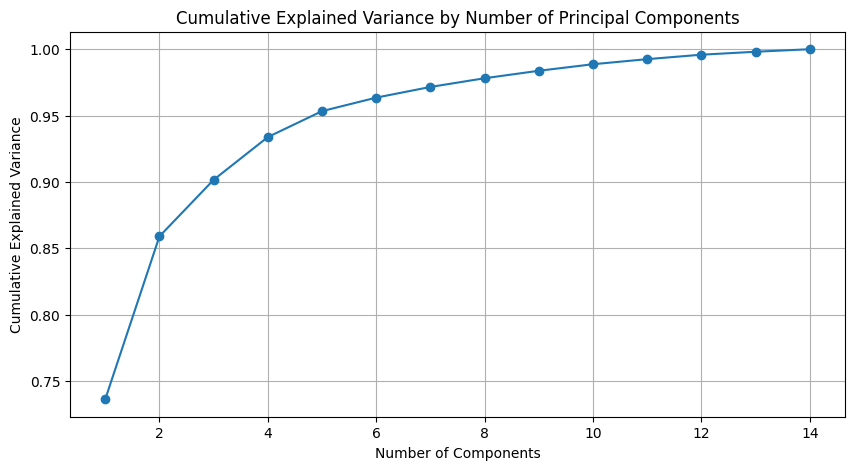


Key PCA Loadings (Top 5 features for the first 3 principal components):
              Top PC1 Features  PC1 Loadings          Top PC2 Features  \
0         language-word_choice       0.29207          content-on_topic   
1             language-clarity       0.28958  content-convincing_ideas   
2  language_sentence-structure       0.28750             content-scope   
3          structure-coherence       0.28640         language-spelling   
4            structure-outline       0.28341         content-plausible   

   PC2 Loadings        Top PC3 Features  PC3 Loadings  
0       0.46783          language_style       0.44758  
1       0.42030    structure-repetition       0.42900  
2       0.36883        language-clarity       0.34137  
3       0.34838    language-word_choice       0.33486  
4       0.33022  structure-text_pattern       0.32502  


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === 1. Select numeric columns ===
numeric_columns = dfall.select_dtypes(include=[np.number]).columns
X = dfall[numeric_columns].dropna()  # remove rows with missing values
#X = X.drop(columns=["user_id"])

# === 2. Standardize the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. Apply PCA ===
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# === 4. Explained Variance Plot ===
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title("Cumulative Explained Variance by Number of Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# === 5. PCA Loadings Matrix ===
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=numeric_columns
)

# === 6. Top contributing features for PC1, PC2, PC3 ===
top_features_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(5)
top_features_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(5)
top_features_pc3 = loadings["PC3"].abs().sort_values(ascending=False).head(5)

top_features_df = pd.DataFrame({
    "Top PC1 Features": top_features_pc1.index,
    "PC1 Loadings": top_features_pc1.values,
    "Top PC2 Features": top_features_pc2.index,
    "PC2 Loadings": top_features_pc2.values,
    "Top PC3 Features": top_features_pc3.index,
    "PC3 Loadings": top_features_pc3.values,
})

print("\nKey PCA Loadings (Top 5 features for the first 3 principal components):")
print(top_features_df)

#### Elbow Method and Silhouette Scores

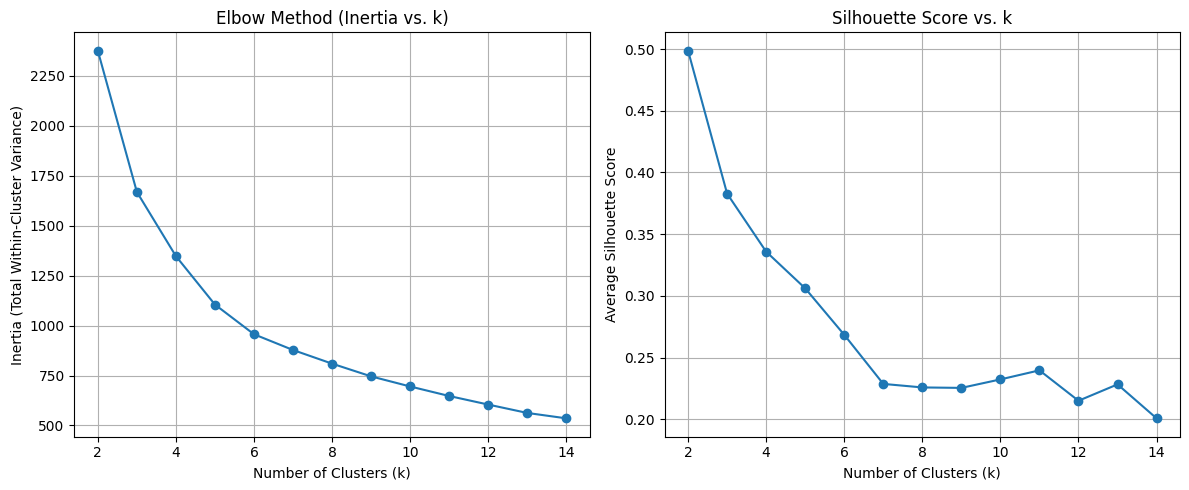

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# First 5 components from PCA-reduced data
X_pca_subset = X_pca[:, :7]

# Range of cluster numbers
K_range = range(2, 15)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_subset)
    
    # Elbow: total within-cluster variance (inertia)
    inertias.append(kmeans.inertia_)
    
    # Silhouette: quality of separation between clusters
    labels = kmeans.labels_
    score = silhouette_score(X_pca_subset, labels)
    silhouette_scores.append(score)

# === Plots ===
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method (Inertia vs. k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Total Within-Cluster Variance)")
plt.grid(True)

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Metrics for Different K values

In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X_eval = X_pca[:, :7]
k_values = [3, 4, 5]
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_eval)
    
    sil = silhouette_score(X_eval, labels)
    db = davies_bouldin_score(X_eval, labels)
    ch = calinski_harabasz_score(X_eval, labels)
    
    results.append({
        "k": k,
        "Silhouette Score (↑)": sil,
        "Davies-Bouldin (↓)": db,
        "Calinski-Harabasz (↑)": ch
    })

# Sonuçları tablo olarak göster
results_df = pd.DataFrame(results)
print(results_df)


   k  Silhouette Score (↑)  Davies-Bouldin (↓)  Calinski-Harabasz (↑)
0  3               0.38281             0.90661              230.45778
1  4               0.33582             1.06287              213.77087
2  5               0.30611             0.92851              211.47976


In [9]:
from sklearn.cluster import KMeans

# Take first 6 PCA component
X_pca_subset = X_pca[:, :7]

# KMeans clustering (for k = 4)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca_subset)

In [10]:
display(len(X_pca_subset))
display(dfall.info())

308

<class 'pandas.core.frame.DataFrame'>
Index: 308 entries, 1 to 4095
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   content-on_topic             308 non-null    float64
 1   content-plausible            308 non-null    float64
 2   content-convincing_ideas     308 non-null    float64
 3   content-scope                308 non-null    float64
 4   structure-coherence          308 non-null    float64
 5   structure-outline            308 non-null    float64
 6   structure-repetition         308 non-null    float64
 7   structure-text_pattern       308 non-null    float64
 8   language-clarity             308 non-null    float64
 9   language-spelling            308 non-null    float64
 10  language-puncutation         308 non-null    float64
 11  language-word_choice         308 non-null    float64
 12  language_sentence-structure  308 non-null    float64
 13  language_style          

None

In [11]:
# add cluster info to original df
df_clustered = dfall.copy()
df_clustered["Cluster"] = cluster_labels

### 2. Results and Plots

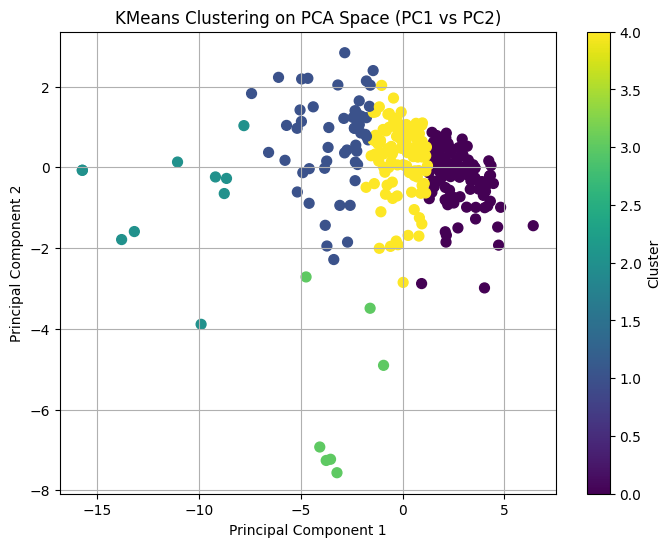

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title("KMeans Clustering on PCA Space (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()

In [13]:
# Compute mean values of numerical columns for each cluster
cluster_profiles = df_clustered.groupby("Cluster").mean(numeric_only=True)

# Print the resulting cluster profiles
print(cluster_profiles)

         content-on_topic  content-plausible  content-convincing_ideas  \
Cluster                                                                  
0                 8.71447            4.43286                   7.50420   
1                 6.87185            3.32515                   5.47487   
2                 1.78000            1.19000                   1.31000   
3                 1.44898            0.76871                   1.19218   
4                 7.99803            4.00724                   6.70835   

         content-scope  structure-coherence  structure-outline  \
Cluster                                                          
0              4.68532              8.07338            4.05592   
1              3.38488              5.14229            2.52185   
2              0.93500              2.12500            0.90000   
3              0.76871              7.53571            3.59694   
4              4.12626              6.90320            3.36121   

         structure

In [14]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# X_scaled: standardize edilmiş veri (PCA uygulanmış olabilir veya olmayabilir)
labels = kmeans.labels_

# 1. Silhouette Score
#sil_score = silhouette_score(X_scaled, labels)

# 2. Davies-Bouldin Index
#db_score = davies_bouldin_score(X_scaled, labels)

# 3. Calinski-Harabasz Index
#ch_score = calinski_harabasz_score(X_scaled, labels)

sil_score = silhouette_score(X_pca_subset, labels)
db_score = davies_bouldin_score(X_pca_subset, labels)
ch_score = calinski_harabasz_score(X_pca_subset, labels)

# Print results
print(f"Silhouette Score:        {sil_score:.3f}  (↑ better)")
print(f"Davies-Bouldin Index:    {db_score:.3f}  (↓ better)")
print(f"Calinski-Harabasz Score: {ch_score:.3f}  (↑ better)")

Silhouette Score:        0.306  (↑ better)
Davies-Bouldin Index:    0.929  (↓ better)
Calinski-Harabasz Score: 211.480  (↑ better)


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def plot_cluster_radar_profiles(df_clustered, macro_columns, cluster_col="Cluster"):
    """
    Displays both unscaled and scaled radar plots to visualize average feature profiles of each cluster.

    Parameters:
    - df_clustered: DataFrame containing clustering information (e.g., df_clustered)
    - macro_columns: Numerical features to include in the radar plot (e.g., ["Fat", "Protein", ...])
    - cluster_col: Name of the column containing cluster labels (default: "Cluster")
    """
    # Compute average values per cluster
    cluster_profiles = df_clustered.groupby(cluster_col)[macro_columns].mean()

    # Scale the values between 0 and 1 for comparative visualization
    scaler = MinMaxScaler()
    cluster_profiles_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_profiles),
        columns=cluster_profiles.columns,
        index=cluster_profiles.index
    )

    # Radar plot setup
    labels = macro_columns
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle

    fig, axs = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))

    # 1. Unscaled radar plot
    ax = axs[0]
    for i, row in cluster_profiles.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
    ax.set_title("Unscaled Grades", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])

    # 2. Scaled radar plot
    ax = axs[1]
    for i, row in cluster_profiles_scaled.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
    ax.set_title("Scaled Grades", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])

    plt.suptitle("Comparison of Cluster Essay Grades", size=16)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.tight_layout()
    plt.show()

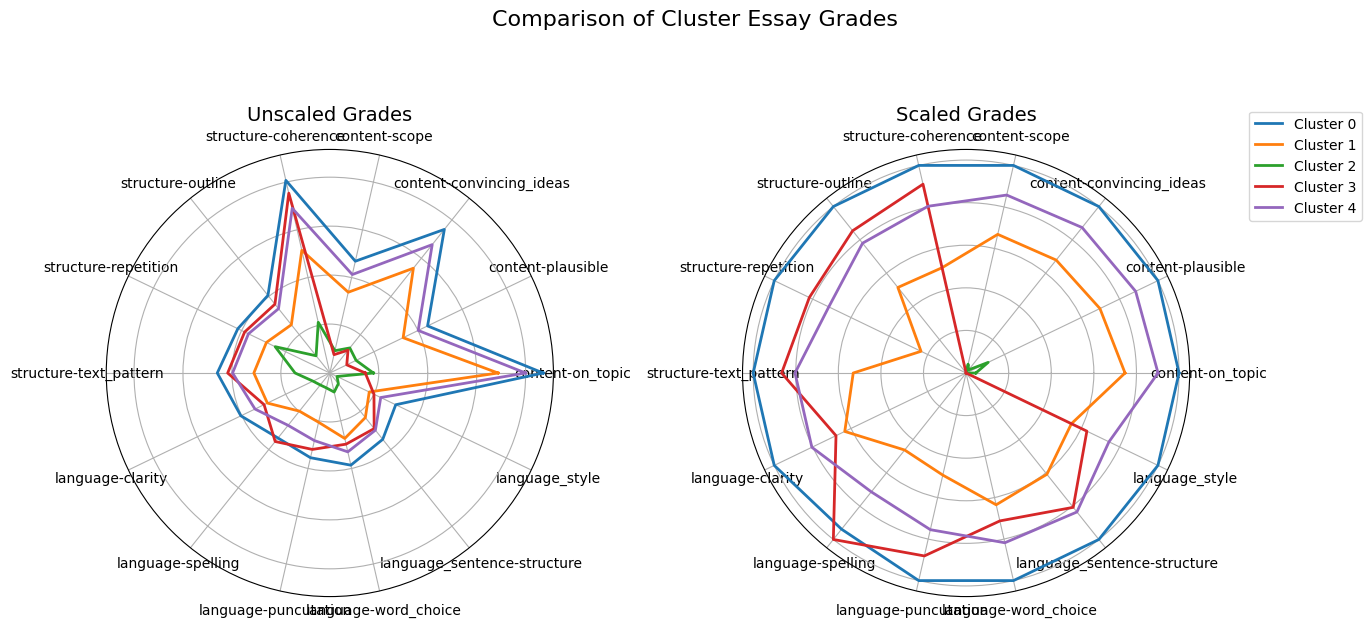

In [16]:
grading_columns = [
    "content-on_topic", "content-plausible", "content-convincing_ideas", "content-scope",
    "structure-coherence", "structure-outline", "structure-repetition", "structure-text_pattern",
    "language-clarity", "language-spelling", "language-puncutation",
    "language-word_choice", "language_sentence-structure", "language_style"
]
plot_cluster_radar_profiles(df_clustered, grading_columns)

#### Additional
For better visualziation, the plots ar adjusted and labels(features) are more readble now. For this, we adjusted the naming convention, overlapping names in the plot and it is more reable now 

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def plot_cluster_radar_profiles(df_clustered, macro_columns, cluster_col="Cluster"):
    """
    Displays both unscaled and scaled radar plots to visualize the average feature profiles of each cluster.
    """

    # Label formatting – manual line breaks to improve readability
    def prettify_label(label):
        manual_breaks = {
            "language-puncutation": "Language\nPunctuation",
            "language-word_choice": "Language\nWord Choice",
            "language_sentence-structure": "Language Sentence\nStructure",
            "structure-coherence": "Structure\nCoherence",
            "content-scope": "Content\nScope",
            "structure-text_pattern": "Structure-Text\nPattern",
            "content-on_topic": "Content\non Topic",
            "content-convincing_ideas": "Content\nConvincing Ideas"
        }
        if label in manual_breaks:
            return manual_breaks[label]
        return label.replace("_", " ").replace("-", " ").title()

    pretty_labels = [prettify_label(col) for col in macro_columns]

    # Cluster-level averages and normalized versions
    cluster_profiles = df_clustered.groupby(cluster_col)[macro_columns].mean()

    scaler = MinMaxScaler()
    cluster_profiles_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_profiles),
        columns=cluster_profiles.columns,
        index=cluster_profiles.index
    )

    # Radar plot setup
    num_vars = len(pretty_labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    colors = plt.cm.tab10.colors  # predefined color palette

    fig, axs = plt.subplots(1, 2, figsize=(15, 7), subplot_kw=dict(polar=True))

    # 1️. Unscaled Radar Plot
    ax = axs[0]
    for idx, (i, row) in enumerate(cluster_profiles.iterrows()):
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values,
                color=colors[idx % len(colors)],
                linestyle='solid',
                linewidth=2,
                alpha=0.9)
    ax.set_title("Unscaled Grades", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(pretty_labels, fontsize=9)
    ax.set_yticklabels([])

    # 2️. Scaled Radar Plot
    ax = axs[1]
    for idx, (i, row) in enumerate(cluster_profiles_scaled.iterrows()):
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values,
                label=f"Cluster {i}",
                color=colors[idx % len(colors)],
                linestyle='solid',
                linewidth=2,
                alpha=0.9)
    ax.set_title("Scaled Grades", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(pretty_labels, fontsize=9)
    ax.set_yticklabels([])

    # Main title and legend
    plt.suptitle("Comparison of Cluster Essay Grades", size=16, x=0.42)

    axs[1].legend(
        title="Clusters",
        loc='upper left',
        bbox_to_anchor=(1.15, 1.05),
        fontsize=10,
        title_fontsize=11,
        frameon=True
    )

    plt.tight_layout(rect=[0, 0, 0.9, 1.1])
    plt.show()

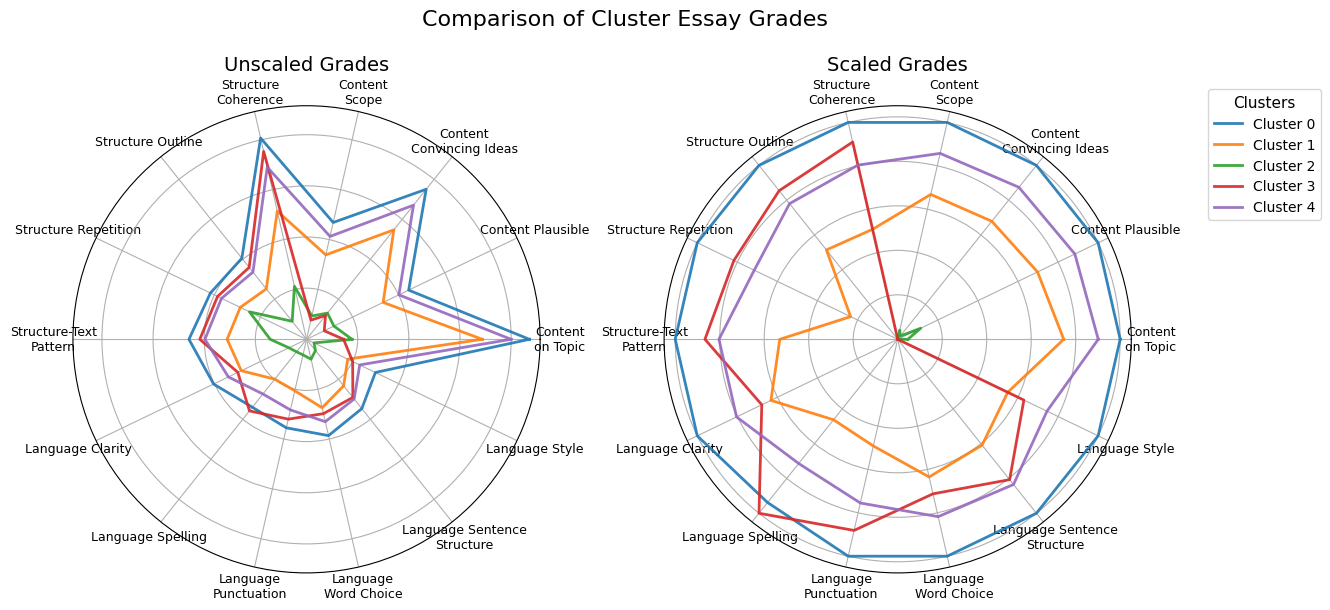

In [21]:
grading_columns = [
    "content-on_topic", "content-plausible", "content-convincing_ideas", "content-scope",
    "structure-coherence", "structure-outline", "structure-repetition", "structure-text_pattern",
    "language-clarity", "language-spelling", "language-puncutation",
    "language-word_choice", "language_sentence-structure", "language_style"
]

plot_cluster_radar_profiles(df_clustered, grading_columns)

In [22]:
# 1. Count the number of samples in each cluster
cluster_counts = df_clustered['Cluster'].value_counts().sort_index()
print("Number of samples in each cluster:\n")
print(cluster_counts)

# 2. Calculate the average value of each score for every cluster
cluster_means = df_clustered.groupby('Cluster').mean(numeric_only=True)

Number of samples in each cluster:

Cluster
0    120
1     53
2     10
3      7
4    118
Name: count, dtype: int64


### 3. Comparison for Different Clusters Across Other Subjects

In [23]:
import pandas as pd

# Load the required CSV files
math_df = pd.read_csv("/home/mlbd-project/updated_data/math_results.csv")
text_df = pd.read_csv("/home/mlbd-project/updated_data/text_results.csv")

# 1. Calculate average math performance per user
math_user_avg = math_df.groupby('user_id')[['points', 'max_points']].sum()
math_user_avg['math_percentage'] = math_user_avg['points'] / math_user_avg['max_points'] * 100
math_percentage = math_user_avg[['math_percentage']]

# 2. Calculate average text performance per user
text_user_avg = text_df.groupby('user_id')[['points', 'max_points']].sum()
text_user_avg['text_percentage'] = text_user_avg['points'] / text_user_avg['max_points'] * 100
text_percentage = text_user_avg[['text_percentage']]

# 3. Join the results with df_clustered based on user_id index
# Assumes that the index of df_clustered is user_id
df_combined = df_clustered.join(math_percentage, how='inner')
df_combined = df_combined.join(text_percentage, how='inner')

# 4. Compute average performance by cluster
avg_performance_by_cluster = df_combined.groupby('Cluster')[['math_percentage', 'text_percentage']].mean().round(2)

# 5. Print the result
print("Average performance percentages by cluster:\n")
print(avg_performance_by_cluster)

Average performance percentages by cluster:

         math_percentage  text_percentage
Cluster                                  
0               60.12000         42.44000
1               53.83000         42.69000
2               40.40000          6.82000
3               50.43000         46.55000
4               55.98000         49.20000


#### Additional Analysis

#### Checking the improvement per user based on their submission number

In [24]:
# 1. Count total number of essays written per student
essay_counts = essay_res_df['user_id'].value_counts().rename('essay_count').to_frame()

# 2. Calculate the difference between average scores of first and last essays
grading_columns = [
    "content-on_topic", "content-plausible", "content-convincing_ideas", "content-scope",
    "structure-coherence", "structure-outline", "structure-repetition", "structure-text_pattern",
    "language-clarity", "language-spelling", "language-puncutation",
    "language-word_choice", "language_sentence-structure", "language_style"
]

# Sort essays by user and time
essay_df_sorted = essay_res_df.sort_values(['user_id', 'time'])

# Extract first and last essays per user
first_essays = essay_df_sorted.groupby('user_id').first()[grading_columns]
last_essays = essay_df_sorted.groupby('user_id').last()[grading_columns]

# Compute average scores
first_avg = first_essays.mean(axis=1).rename('first_avg_score')
last_avg = last_essays.mean(axis=1).rename('last_avg_score')

# Calculate score improvement
score_change = (last_avg - first_avg).rename('score_change')

# 3. Combine essay count and score improvement
essay_stats = pd.concat([essay_counts, score_change], axis=1)

# 4. Join with df_clustered (assuming index is user_id)
df_combined = df_clustered[['Cluster']].join(essay_stats, how='inner')

# 5. Compute average essay statistics per cluster
cluster_summary = df_combined.groupby('Cluster')[['essay_count', 'score_change']].mean().round(2)

# Display results
print(cluster_summary)

         essay_count  score_change
Cluster                           
0            5.95000       0.35000
1            4.19000       0.46000
2            1.90000       0.16000
3            2.57000       0.35000
4            8.56000       0.29000


#### Checking the success by looking math subjects across differnt clusters

In [25]:
import pandas as pd

# Load question metadata
question_df = pd.read_csv("/home/mlbd-project/updated_data/math_questions_clean.csv")

# Rename columns for merging: match math_df["question"] with question_df["question_id"]
question_df = question_df.rename(columns={"question_id": "question", "skill_id": "subject"})
question_map_trimmed = question_df[['question', 'exam_id', 'subject']]

# Merge subject information into math_df
math_df = pd.merge(
    math_df,
    question_map_trimmed,
    on=['question', 'exam_id'],
    how='inner'
)

# Calculate success rate per question
math_df['correct_ratio'] = math_df['points'] / math_df['max_points'] * 100

# Compute average success rate per user per subject
user_subject_score = math_df.groupby(['user_id', 'subject'])['correct_ratio'].mean().reset_index()

# Join with cluster information
df_clustered_reset = df_clustered.reset_index()[['user_id', 'Cluster']]
merged = pd.merge(user_subject_score, df_clustered_reset, on='user_id', how='inner')

# Final result: average success rate by subject and cluster
cluster_topic_score = merged.groupby(['subject', 'Cluster'])['correct_ratio'].mean().unstack().round(2)

# Display the result (clusters as rows, subjects as columns)
display(cluster_topic_score.T)

subject,Geometrie,Textaufgaben,Zahlen und Arithmetik
Cluster,,,
0,62.74000,66.28000,61.51000
1,54.13000,59.26000,61.16000
2,65.00000,49.92000,66.22000
3,30.54000,47.71000,46.82000
4,50.30000,64.03000,57.61000


In [26]:
merged.groupby(['Cluster', 'subject']).size().unstack()

subject,Geometrie,Textaufgaben,Zahlen und Arithmetik
Cluster,,,
0,64,101,104
1,32,42,43
2,4,7,9
3,3,4,4
4,59,85,86
